# Homework 4

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3 as sql

## Joining Data

In the previous homework we cleaned the data in the file 'cell_phones_total.csv'. Now we want to combine the cleaned version of this file with the 'pop_data.csv' file to calculate the number of cell phones per capita. We begin by copying the code for the cleaned version and then handle the missing values in the 'pop_data.csv' file.

In [241]:
# Read the csv file
cell_phones = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")

# Convert strings like 'k', 'M', 'B' to numbers
year_columns = cell_phones.columns[1:]  # All columns except the first one, which represents the country identifier
def convert_str_to_number(x):
    if pd.isnull(x):
        return x  # return nan unchanged
    if isinstance(x, str):
        x = x.strip()  # Remove extra whitespaces
        if x.endswith('k'):
            return float(x[:-1]) * 1e3
        elif x.endswith('M'):
            return float(x[:-1]) * 1e6
        elif x.endswith('B'):
            return float(x[:-1]) * 1e9
    try:
        return float(x)  # Convert numeric strings or numbers to float
    except:
        return pd.NA  # if conversion fails, return missing value nan

for col in year_columns:
    cell_phones[col] = cell_phones[col].apply(convert_str_to_number)

# Forward fill 
cell_phones[year_columns] = cell_phones[year_columns].fillna(method='ffill', axis=1)

# Backward fill 
cell_phones[year_columns] = cell_phones[year_columns].fillna(method='bfill', axis=1)

Before combining the datasets we need to fix the missing values in 'pop_data.csv'. We could assume that the population grows steadily each year and use forward and backward fill to fill in the missing data. However this might not work well here because country 'ISX' has only empty cells and 'PSE' is missing almost half of its data. This could give us unaccurate results so I decided to remove these countries from the dataset using dropna(). 

In [251]:
df_pop = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")

print("Missing values before using dropna:")
print(df_pop.isna().sum())

# Drop rows with any missing values 
df_pop.dropna(inplace=True)

print("Missing values after using dropna:")
print(df_pop.isna().sum())

Missing values before using dropna:
Unnamed: 0    0
iso-3         0
1960          2
1961          2
1962          2
             ..
2016          1
2017          1
2018          1
2019          1
2020          1
Length: 63, dtype: int64
Missing values after using dropna:
Unnamed: 0    0
iso-3         0
1960          0
1961          0
1962          0
             ..
2016          0
2017          0
2018          0
2019          0
2020          0
Length: 63, dtype: int64


We need to reshape pop_data.csv and cell_phones.csv from their wide formats into a long format before combining them. This will make the data more consistent and easier to work with. We will use pd.melt to do this. 

In [314]:
# Reshape cell phone data 
cell_phones_data = pd.melt(
    cell_phones,
    id_vars=['iso-3'],       
    var_name='year',         
    value_name='n_cellphones' 
)
# Convert the 'year' column to integer type
cell_phones_data['year'] = cell_phones_data['year'].astype(int)

# Identify valid year columns in the population data
valid_years = [col for col in population.columns if col.isdigit()]

# Reshape population data to long format
population_data = pd.melt(
    population,
    id_vars=['iso-3'],     
    value_vars=valid_years,  
    var_name='year',         
    value_name='population'  
)
# Change the 'year' column to integer
population_data['year'] = population_data['year'].astype(int)

Now we want to merge 'cell_phones_data' and 'population_data' using 'pd.merge' and then use 'head()' to show a table similar to the one in the instructions. 

In [316]:
# Merge the reshaped datasets
merged_data = pd.merge(
    cell_phones_data,
    population_data,
    on=['iso-3', 'year'],
    how='inner'  # Keep only rows with matching iso-3 and year
)
merged_data.head()

,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
1,AFG,1960,0.0,8622466.0
2,AGO,1960,0.0,5357195.0
3,ALB,1960,0.0,1608800.0
4,AND,1960,0.0,9443.0


We can see that the table matches the one in the instructions. However we want to replace the 'iso-3' code with the country name to make the result more readable. We can do this by using the 'country_data.csv' file.

In [418]:
country = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")

# Rename 'alpha-3' to 'iso-3' to match the column in merged_data
country_data.rename(columns={'name': 'country_name', 'alpha-3': 'iso-3'}, inplace=True)

# Merge the datasets on 'country_name'
merged_data = pd.merge(
    merged_data,
    country_data[['country_name', 'iso-3']],  # Merge by 'country_name' and keep 'iso-3'
    on='iso-3',
    how='left'
)

# Reorder columns to keep only the relevant ones
merged_data = merged_data[['country_name', 'year', 'n_cellphones', 'population']]
merged_data.head()

,country_name,year,n_cellphones,population
0,Aruba,1960,0.0,54608.0
1,Afghanistan,1960,0.0,8622466.0
2,Angola,1960,0.0,5357195.0
3,Albania,1960,0.0,1608800.0
4,Andorra,1960,0.0,9443.0


We now want to calculate the number of phones per capita, which is done by dividing number of cell phones with the population. 

In [442]:
# Calculate the number of phones per capita
merged_data['phones_per_capita'] = merged_data['n_cellphones'] / merged_data['population']

# Filter the data for the years 2015-2019
merged_data_2015_2019 = merged_data[merged_data['year'].isin([2015, 2016, 2017, 2018, 2019])]

# Create a table where countries are columns, years as rows and phones_per_capita as values
pivot_data = merged_data_2015_2019.pivot_table(
    index='year', 
    columns='country_name', 
    values='phones_per_capita'
)

# Sort the countries by the number of phones per capita in 2019
pivot_data = pivot_data.sort_values(by=2019, axis=1, ascending=False)

pivot_data

country_name,Macao,Hong Kong,United Arab Emirates,Antigua and Barbuda,Seychelles,Montenegro,Thailand,South Africa,Lithuania,Russian Federation,...,Niger,Djibouti,Marshall Islands,South Sudan,Ethiopia,Central African Republic,Micronesia (Federated States of),Eritrea,Korea (Democratic People's Republic of),American Samoa
year,,,,,,,,,,,,,,,,,,,,,
2015,3.088231,2.290401,2.007424,1.956838,1.584260,1.623379,1.465266,1.574902,1.438943,1.575329,...,0.445148,0.312047,0.313702,0.259060,0.412796,0.257297,0.205551,0.142215,0.128276,0.043802
2016,3.143510,2.398931,2.212521,1.987545,1.605459,1.671212,1.699547,1.460416,1.464317,1.586505,...,0.357045,0.337157,0.320718,0.243988,0.486261,0.254885,0.212872,0.150359,0.142184,0.044600
2017,3.210102,2.488773,2.183431,2.019337,1.742433,1.671024,1.720777,1.562467,1.541506,1.570970,...,0.403902,0.358574,0.339076,0.261770,0.365996,0.236154,0.209182,0.204596,0.149316,0.045489
2018,3.348741,2.670209,2.199084,2.008164,1.849900,1.816057,1.757400,1.611451,1.638383,1.585018,...,0.388890,0.373629,0.347909,0.353043,0.356341,0.251238,0.208241,0.201720,0.148607,0.046465
2019,3.284849,2.863650,2.127739,1.997460,1.987196,1.848791,1.823083,1.669907,1.667778,1.661978,...,0.374519,0.367786,0.357718,0.351275,0.347001,0.293704,0.207400,0.198639,0.147930,0.047548


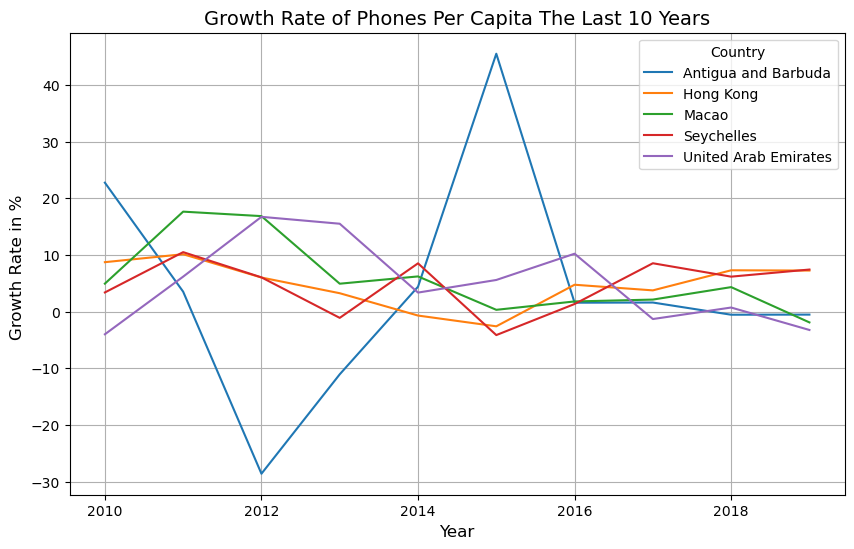

In [448]:
# Calculate growth rate over the last 10 years
growth_rate = pivot_table.pct_change() * 100

# Filter data for the last 10 years
growth_rate_last_10_years = growth_rate[-10:]

# Plot the growth rates
plt.figure(figsize=(10, 6))
for country in growth_rate_last_10_years.columns:
    plt.plot(
        growth_rate_last_10_years.index,
        growth_rate_last_10_years[country],
        label=country
    )

plt.title("Growth Rate of Phones Per Capita The Last 10 Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Growth Rate in % ", fontsize=12)
plt.legend(title="Country", fontsize=10)
plt.grid(True)
plt.show()


From the graph we can observe that the variation between the countries is relatively consistent, however Antigua and Barbuda stands out with more fluctuations, especially between the year 2012-2016. This suggests that the country experienced a more unstable growth in cell phones per capita compared to the other countries in the analysis.

## SQL

We start with opening the database 'user_actions.db' and set up a cursor to run commands on it.

In [454]:
conn = sql.connect("user_actions.db")
cursor = conn.cursor()

The first task is to retrieve the usernames of all users who have performed the "signup" action. 

In [486]:
# Run the SQL query to fetch data
query = """
SELECT username
FROM user_actions
WHERE action = 'signup';
"""
cursor.execute(query) 
results = cursor.fetchall()  # Fetch the results

print(results)

[('user34',), ('user28',), ('user1',), ('user24',), ('user15',), ('user20',), ('user18',), ('user25',), ('user3',), ('user9',), ('user27',), ('user16',), ('user17',), ('user4',), ('user8',), ('user13',), ('user19',), ('user31',), ('user10',), ('user23',), ('user11',), ('user33',), ('user12',), ('user29',), ('user21',), ('user6',), ('user14',), ('user30',), ('user7',), ('user26',), ('user22',), ('user5',), ('user35',), ('user2',), ('user32',)]


In [ ]:
The usernames are now retrieved, however we are also interested to see how number of log entries each user have made. 

In [543]:
# SQL query to find the total number of log entries for each user
query2 = """
SELECT user_id, username, COUNT(*) AS log_entries
FROM user_actions
WHERE action = 'login' 
GROUP BY user_id, username;
"""

#Execute and fetch the results
cursor.execute(query2)
results2 = cursor.fetchall() 

# Using pandas to display more readable results
df = pd.DataFrame(results2, columns=['user_id', 'username', 'log_entries'])
df

,user_id,username,log_entries
0,1,user1,97
1,2,user2,139
2,3,user3,101
3,4,user4,425
4,5,user5,182
5,6,user6,448
6,7,user7,358
7,8,user8,318
8,9,user9,109
9,10,user10,163


From the table above we can observe that the user ID matches the last digit of the username. In addition, the number of log entries differs significantly between users with some having over 400 entries while others have around 20 log entries. We are now interested to find users who signed upp and logged in on the same day. 

In [530]:
# Query to find users who signed up and logged in on the same day
query3 = """
SELECT DISTINCT ua1.user_id, ua1.username
FROM user_actions ua1
JOIN user_actions ua2
  ON ua1.user_id = ua2.user_id
WHERE ua1.action = 'signup'
  AND ua2.action = 'login'
  AND DATE(ua1.timestamp) = DATE(ua2.timestamp);
"""

# Execute the query
cursor.execute(query3)
results3 = cursor.fetchall()

# Using pandas to dislay the results
df = pd.DataFrame(results3, columns=['User ID', 'Username'])
df


,User ID,Username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


In the query, ua1 and ua2 are shortcuts for the user_actions table, where ua1 is used to find signup actions while ua2 is used to find login actions. In addition, DATE(ua1.timestamp) = DATE(ua2.timestamp) makes sure we only look at actions done on the same day even if they happened at different times. From the table above, we can see that 8 out of 35 users signed up and logged in on the same day.


## Regex

In [539]:
import re 

In this task we want to extract all the hastags from a given comment using regex. 

In [557]:
# Using the first comment in 'comment.txt' 
comment = "Great post! #programming #tips"

# Extracting hashtags
hashtags = re.findall(r'#\w+', comment)
hashtags

['#programming', '#tips']

We can see that the regex successfully extracted the hasttags from the comment.

In [561]:
# The second comment from 'comments.txt' 
comment_2 = "Enjoyed the article. #coding #python"

# Regular expression to find comments that have both #programming and #python in them 
regex = r'(?=.*#programming)(?=.*#python)'

# Apply regex to comment 2 and check if it matches
if re.search(regex, comment_2):
    print("Match found!")
else:
    print("No match.")


No match.


We can see that the regex doesn't match with the second comment in 'common.txt' since it doesn't contain #programming. 